In [ ]:
# Прогноз продаж 33 категорий товаров в 54 магазинах осуществлялся для каждой категории отдельно (Kaggle). 
# В примере ниже показан прогноз одной группы товаров с помощью линейной регрессии, бустинга и статистической модели
# Наилучшие результаты получены при применении статистической модели

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, date
from category_encoders.target_encoder import TargetEncoder

In [22]:
df=pd.read_csv("D:/store_equador/train_stor.csv")
df_test=pd.read_csv("D:/store_equador/test.csv")

In [23]:
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [24]:
#объединяю тренировочную и тестовую часть
df=pd.concat([df, df_test], ignore_index=True)

In [25]:
df.describe()


,id,store_nbr,sales,onpromotion
count,3.029400e+06,3.029400e+06,3.000888e+06,3.029400e+06
mean,1.514700e+06,2.750000e+01,3.577757e+02,2.643830e+00
std,8.745126e+05,1.558579e+01,1.101998e+03,1.233287e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.573498e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.514700e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.272049e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.029399e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [7]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [157]:
#создаю датасет для категории 'AUTOMOTIVE'
df_A=df.query("family=='AUTOMOTIVE'")

In [158]:
# удаляю ненужные колонки
df_A.drop(columns=['id', 'family'], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_11540\768820071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A.drop(columns=['id', 'family'], inplace=True)


In [111]:
# формирую характеристики для обучения и целевую переменную. 
X=df_A.copy()
X['lag_1']=X['sales'].shift(54*16*2)
X['lag_2']=X['sales'].shift(54*16*3)
X['lag_3']=X['sales'].shift(54*16*4)
X=X.dropna(subset='lag_3')
y=X.sales

In [88]:
X.corr()

C:\Users\User\AppData\Local\Temp\ipykernel_12992\1968499000.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X.corr()


,store_nbr,sales,onpromotion,lag_1,lag_2,lag_3
store_nbr,1.000000,0.202837,0.122939,0.202038,0.201130,0.199612
sales,0.202837,1.000000,0.211533,0.452828,0.526567,0.511120
onpromotion,0.122939,0.211533,1.000000,0.113580,0.120521,0.127613
lag_1,0.202038,0.452828,0.113580,1.000000,0.462573,0.452898
lag_2,0.201130,0.526567,0.120521,0.462573,1.000000,0.463223
lag_3,0.199612,0.511120,0.127613,0.452898,0.463223,1.000000


In [112]:
# Разделяю выборку на тренировочную и валидационную часть. Тестовая часть в выборку не включена
X.drop(columns=['sales', 'date'], inplace=True)
Xtrain=X[:-1728]
ytrain=y[:-1728]
Xtest=X[-1728:-864]
ytest=y[-1728:-864]
# Кодирую переменную "Номер магазина" 
tgt_enc=TargetEncoder(cols=['store_nbr'], smoothing=1)
tgt_enc.fit(Xtrain, ytrain)
Xtrain=tgt_enc.transform(Xtrain)
Xtest=tgt_enc.transform(Xtest)
# Нормализую переменные
stsc=StandardScaler()
stsc.fit(Xtrain)
Xtrain=pd.DataFrame(stsc.transform(Xtrain), columns=Xtrain.columns)
Xtest=pd.DataFrame(stsc.transform(Xtest), columns=Xtest.columns)


In [79]:
Xtrain

,store_nbr,onpromotion,lag_1,lag_2,lag_3
0,-0.715350,-0.157778,-0.982201,-0.817156,-0.973468
1,-0.758291,-0.157778,-0.339072,-0.978068,-0.973468
2,0.142074,-0.157778,1.429531,-0.817156,-0.973468
3,-0.343504,-0.157778,-0.339072,-0.173508,-0.973468
4,-0.140155,-0.157778,0.947184,-0.817156,-0.973468
...,...,...,...,...,...
86611,-0.107638,-0.157778,-0.499855,0.631053,0.315732
86612,-0.195543,-0.157778,-0.499855,-0.817156,0.960332
86613,-0.460814,-0.157778,0.304056,-0.656244,-0.490018
86614,-0.216236,-0.157778,-0.017508,0.309228,-0.490018


In [80]:
# Обучаю линейную регрессиюю Рассчитываю MAE, R2, RMSLE
model=LinearRegression()
model.fit(Xtrain, ytrain)
pred=model.predict(Xtest)
MAE=mean_absolute_error(ytest, pred)
R2=r2_score(ytest, pred)
pred_d=pd.DataFrame({'id':Xtest.index, 'pred':pred})
pred_d[pred_d<0]=0
RMSLE=np.sqrt(mean_squared_log_error(ytest, pred_d['pred']))
MAE, R2, RMSLE

(3.088357257192897, 0.4048676645409449, 0.548243162279194)

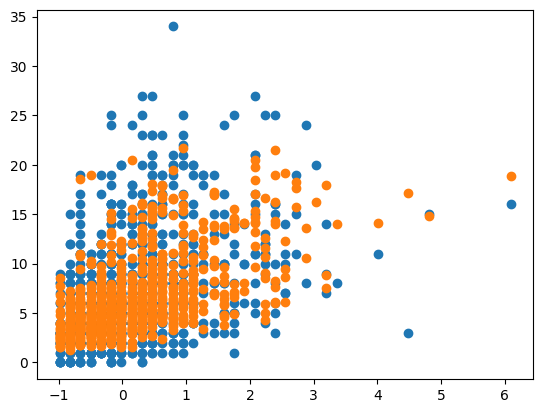

In [83]:
# Строю зависимость тестовых значение целевой переменной и предсказанных значений от переменной "lag_1"
plt.scatter(Xtest.lag_1, ytest)
plt.scatter(Xtest.lag_1, pred)

In [8]:
# Обучаю модель бустинга
model=XGBRegressor()
model.fit(Xtrain, ytrain)
pred=model.predict(Xtest)
MAE=mean_absolute_error(ytest, pred)
R2=r2_score(ytest, pred)
pred_d=pd.DataFrame({'id':Xtest.index, 'pred':pred})
pred_d[pred_d<0]=0
RMSLE=np.sqrt(mean_squared_log_error(ytest, pred_d['pred']))
MAE, R2, RMSLE

(3.003819749035217, 0.4514563241480416, 0.5332271302743259)

In [184]:
# Использую статистическую модель
df=pd.read_csv("D:/store_equador/train_stor.csv")
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [186]:
df_A_1nbr=df.query("family=='AUTOMOTIVE' & store_nbr==1")

In [168]:
from etna.datasets.tsdataset import TSDataset
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

c:\users\user\python39\lib\site-packages\etna\settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
c:\users\user\python39\lib\site-packages\etna\settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
c:\users\user\python39\lib\site-packages\etna\settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
c:\users\user\python39\lib\site-packages\etna\settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
c:\u

In [187]:
df_etna=df_A_1nbr[['date', 'sales']].copy()
df_etna=df_etna.rename({'date':'timestamp', 'sales':'target'}, axis=1)
df_etna['segment']='main'

In [188]:
df_etna

,timestamp,target,segment
0,2013-01-01,0.0,main
1782,2013-01-02,2.0,main
3564,2013-01-03,3.0,main
5346,2013-01-04,3.0,main
7128,2013-01-05,5.0,main
...,...,...,...
2991978,2017-08-11,1.0,main
2993760,2017-08-12,6.0,main
2995542,2017-08-13,1.0,main
2997324,2017-08-14,1.0,main


In [189]:
df_etna = TSDataset.to_dataset(df_etna)
df_etna

segment,main
feature,target
timestamp,
2013-01-01,0.0
2013-01-02,2.0
2013-01-03,3.0
2013-01-04,3.0
2013-01-05,5.0
...,...
2017-08-11,1.0
2017-08-12,6.0


In [190]:
ts=TSDataset(df_etna, freq='D')

c:\users\user\python39\lib\site-packages\etna\datasets\tsdataset.py:145: UserWarning: You probably set wrong freq. Discovered freq in you data is None, you set D
  warnings.warn(


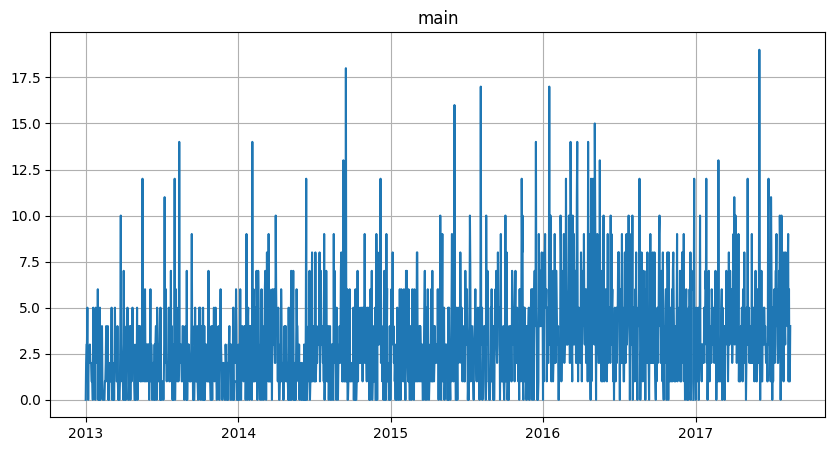

In [191]:
ts.plot()

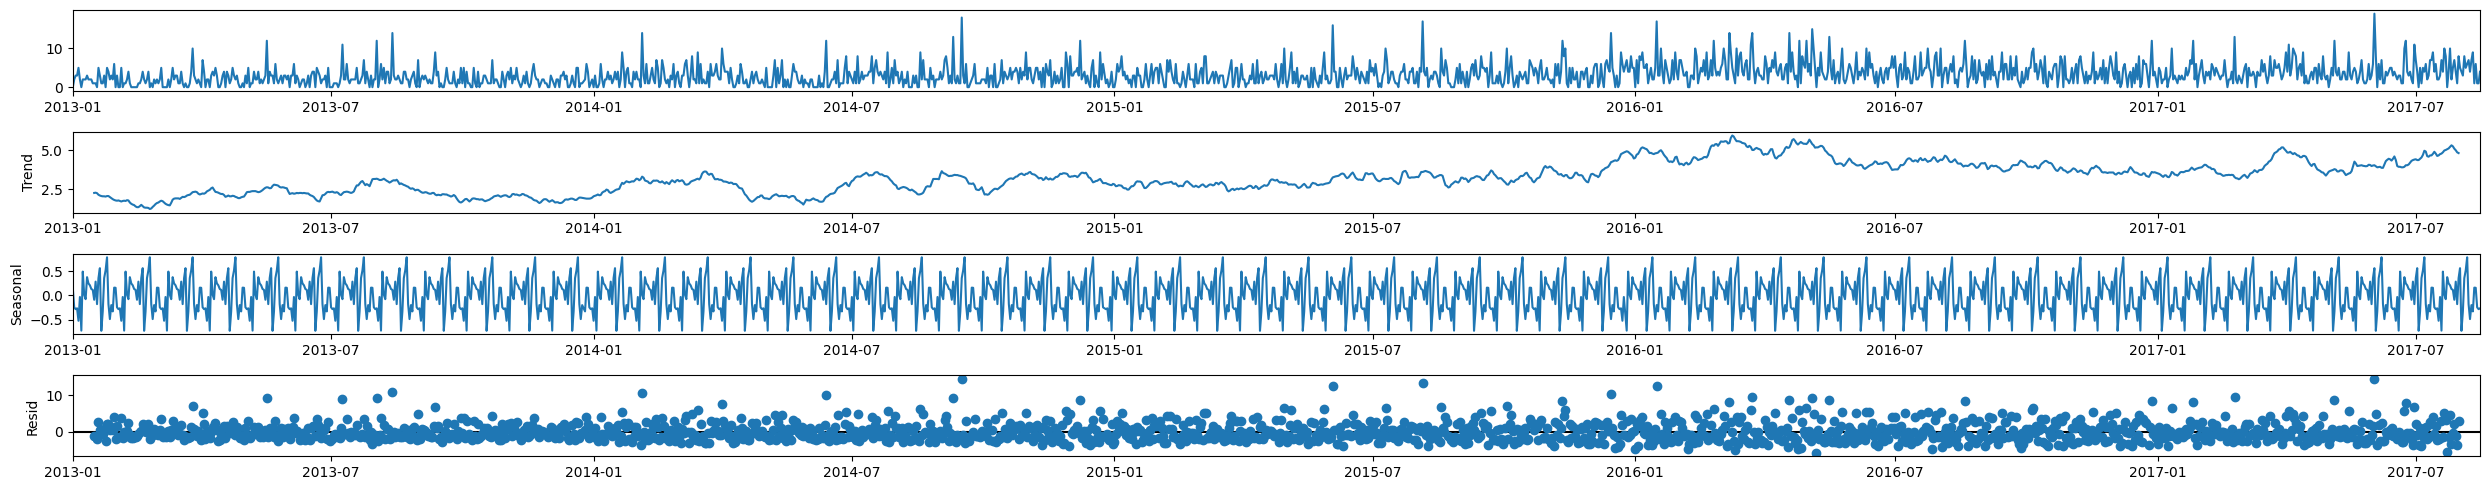

In [193]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(df_etna, period=30)
plt.rc('figure', figsize=(25,5))
res_plot=res.plot()

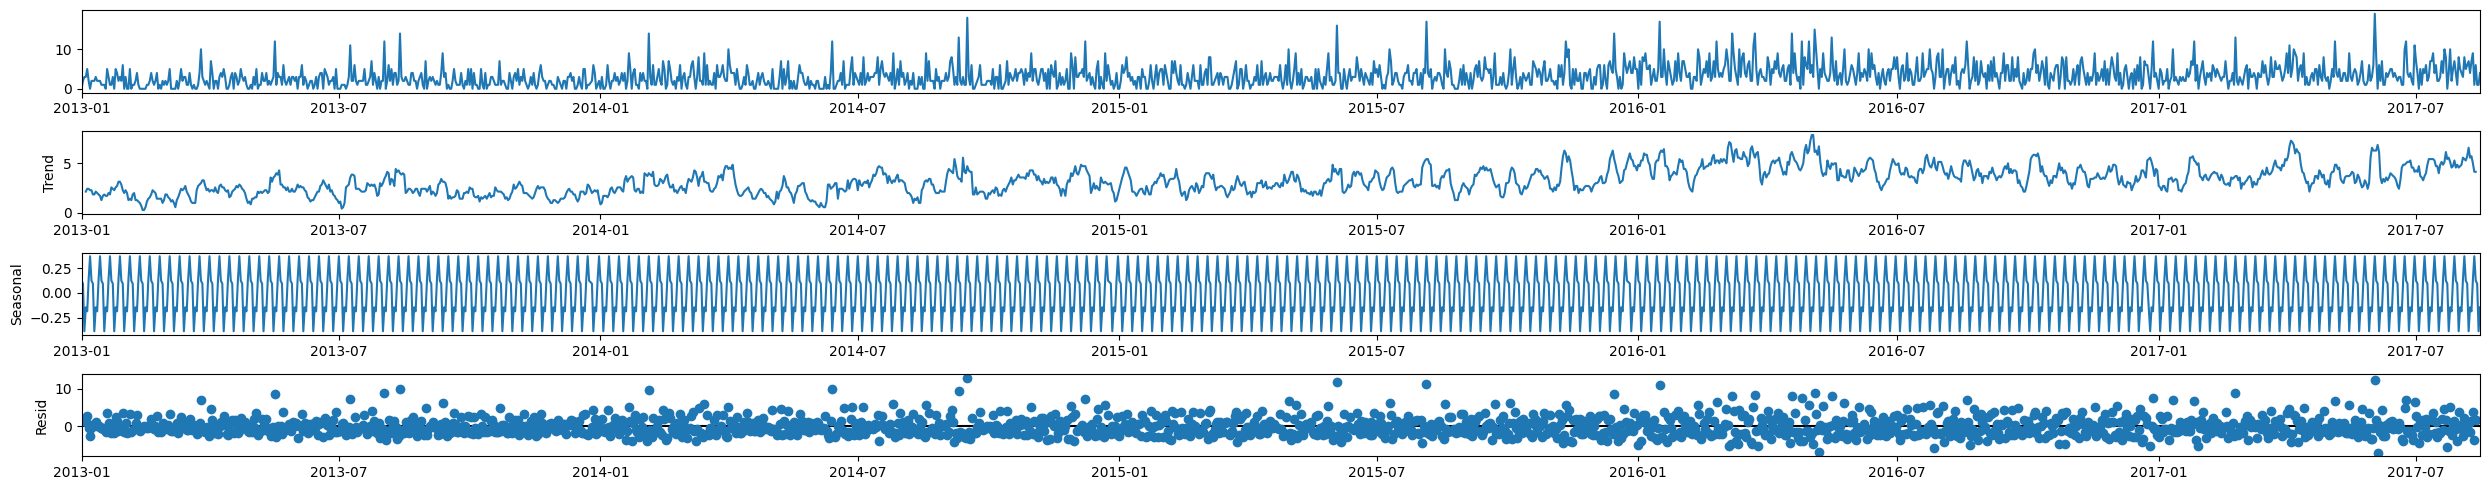

In [199]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(df_etna, period=7)
plt.rc('figure', figsize=(25,5))
res_plot=res.plot()

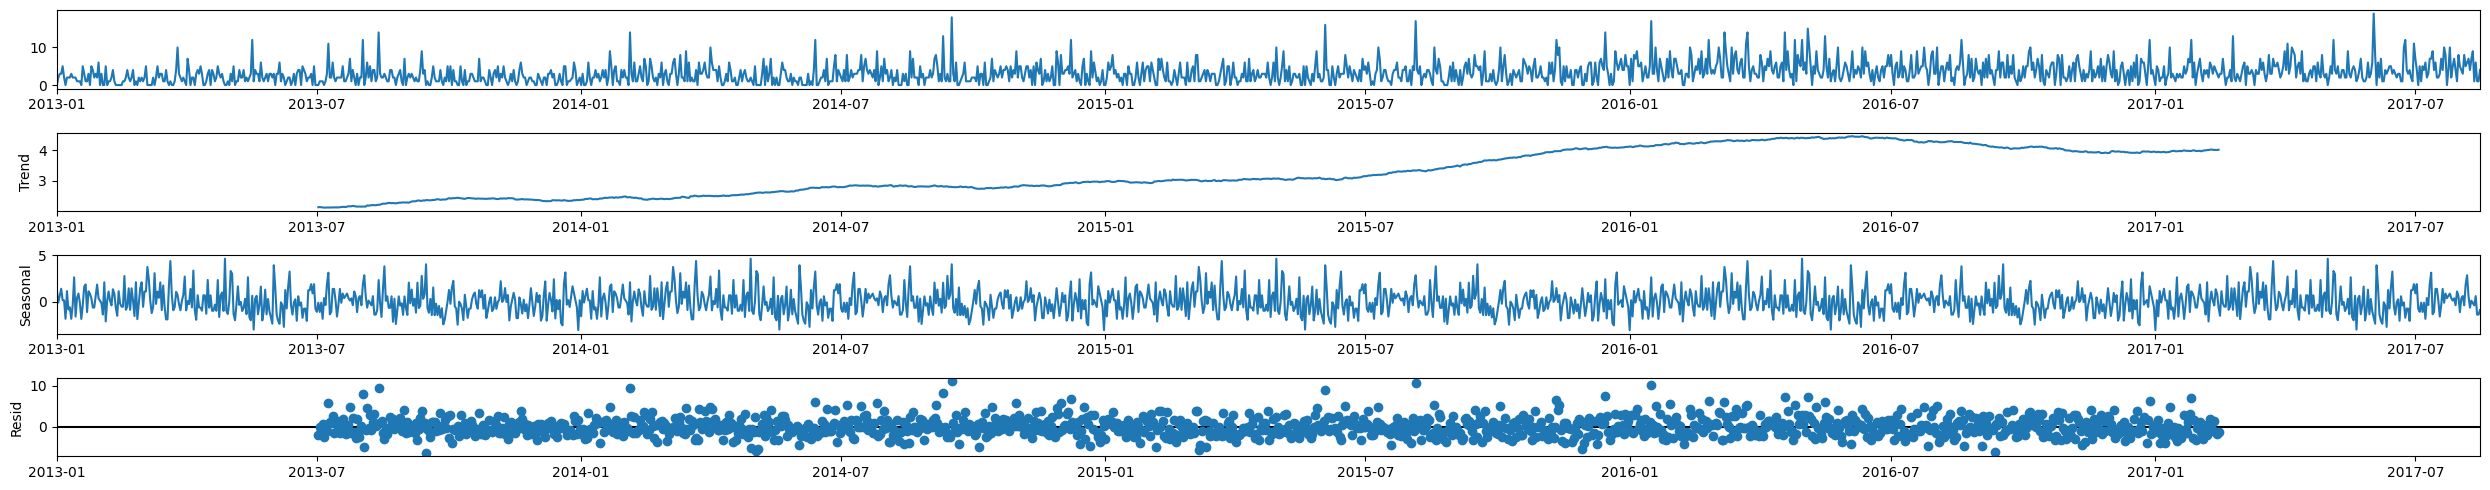

In [195]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(df_etna, period=365)
plt.rc('figure', figsize=(25,5))
res_plot=res.plot()

In [210]:
train_ts, test_ts = ts.train_test_split(
    train_start="2013-01-01",
    train_end="2017-07-30",
    test_start="2017-07-31",
    test_end="2017-08-15")

In [260]:
from etna.metrics import SMAPE, MAE, MSLE

In [215]:
from etna.analysis import plot_forecast

In [217]:
from etna.models import ProphetModel

In [285]:
# Рассчитываю прогноз на аддитивной модели
HORIZON=16
model = ProphetModel()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
smape(y_true=test_ts, y_pred=forecast_ts), mae(y_true=test_ts, y_pred=forecast_ts)

13:42:40 - cmdstanpy - INFO - Chain [1] start processing
13:42:40 - cmdstanpy - INFO - Chain [1] done processing
c:\users\user\python39\lib\site-packages\etna\datasets\tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


({'main': 49.619245531173675}, {'main': 2.078470863128178})

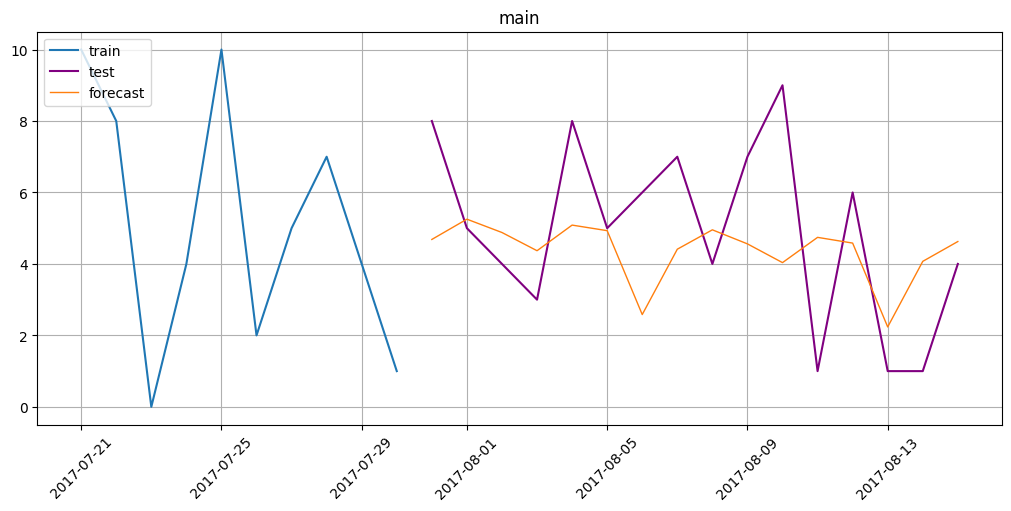

In [229]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [286]:
msle = MSLE()
rmsle=np.sqrt(msle(y_true=test_ts, y_pred=forecast_ts)['main'])
rmsle

0.4992972598526837